## Super-resolution models

### EDSR


In [17]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Add, Conv2D, Input, Lambda
from tensorflow.keras.models import Model

DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255


def edsr(scale, num_filters=64, num_res_blocks=8, res_block_scaling=None):
    """Creates an EDSR model."""
    x_in = Input(shape=(None, None, 3))
    x = Lambda(normalize)(x_in)

    x = b = Conv2D(num_filters, 3, padding='same')(x)
    for i in range(num_res_blocks):
        b = res_block(b, num_filters, res_block_scaling)
    b = Conv2D(num_filters, 3, padding='same')(b)
    x = Add()([x, b])

    x = upsample(x, scale, num_filters)
    x = Conv2D(3, 3, padding='same')(x)

    x = Lambda(denormalize)(x)
    return Model(x_in, x, name="edsr")


def res_block(x_in, filters, scaling):
    """Creates an EDSR residual block."""
    x = Conv2D(filters, 3, padding='same', activation='relu')(x_in)
    x = Conv2D(filters, 3, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_in, x])
    return x


def upsample(x, scale, num_filters):
    def upsample_1(x, factor, **kwargs):
        """Sub-pixel convolution."""
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
        return Lambda(pixel_shuffle(scale=factor))(x)

    if scale == 2:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
    elif scale == 3:
        x = upsample_1(x, 3, name='conv2d_1_scale_3')
    elif scale == 4:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
        x = upsample_1(x, 2, name='conv2d_2_scale_2')

    return x


def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)


def normalize(x):
    return (x - DIV2K_RGB_MEAN) / 127.5


def denormalize(x):
    return x * 127.5 + DIV2K_RGB_MEAN

### WDSR

## Model training

### Data

In [18]:
from data import DIV2K

train = DIV2K(scale=4, downgrade='bicubic', subset='train')
train_ds = train.dataset(batch_size=16, random_transform=True)

### Pixel loss

In [19]:
import os

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

# Create directory for saving model weights
weights_dir = 'weights/article'
os.makedirs(weights_dir, exist_ok=True)

# EDSR baseline as described in the EDSR paper (1.52M parameters)
model_edsr = edsr(scale=4, num_res_blocks=16)

# Adam optimizer with a scheduler that halfs learning rate after 200,000 steps
optim_edsr = Adam(learning_rate=PiecewiseConstantDecay(boundaries=[20], values=[1e-4, 5e-5]))

# Compile and train model for 300,000 steps with L1 pixel loss
model_edsr.compile(optimizer=optim_edsr, loss='mean_absolute_error')
model_edsr.fit(train_ds, epochs=3, steps_per_epoch=10)

# Save model weights
model_edsr.save_weights(os.path.join(weights_dir, 'weights-edsr-16-x4.h5'))

Epoch 1/3
 9/10 [==========================>...] - ETA: 0s - loss: 72.7879

KeyboardInterrupt: 

In [ ]:
from model.wdsr import wdsr_b

# Custom WDSR B model (0.62M parameters)
model_wdsr = wdsr_b(scale=4, num_res_blocks=32)

# Adam optimizer with a scheduler that halfs learning rate after 200,000 steps
optim_wdsr = Adam(learning_rate=PiecewiseConstantDecay(boundaries=[20], values=[1e-3, 5e-4]))

# Compile and train model for 300,000 steps with L1 pixel loss
model_wdsr.compile(optimizer=optim_wdsr, loss='mean_absolute_error')
model_wdsr.fit(train_ds, epochs=3, steps_per_epoch=10)

# Save weights
model_wdsr.save_weights(os.path.join(weights_dir, 'weights-wdsr-b-32-x4.h5'))

### Perceptual loss

In [ ]:
from model import srgan
import time

# Used in content_loss
mean_squared_error = tf.keras.losses.MeanSquaredError()

# Used in generator_loss and discriminator_loss
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Model that computes the feature map after the 4th convolution 
# before the 5th max-pooling layer in VGG19. This is layer 20 in
# the corresponding Keras model.
efficientNet = srgan.efficientNet_54()

# EDSR model used as generator in SRGAN
generator = edsr(scale=4, num_res_blocks=16)
generator.load_weights(os.path.join(weights_dir, 'weights-edsr-16-x4.h5'))

# SRGAN discriminator
discriminator = srgan.discriminator()

# Optmizers for generator and discriminator. SRGAN will be trained for
# 200,000 steps and learning rate is reduced from 1e-4 to 1e-5 after
# 100,000 steps
schedule = PiecewiseConstantDecay(boundaries=[10], values=[1e-4, 1e-5])
generator_optimizer = Adam(learning_rate=schedule)
discriminator_optimizer = Adam(learning_rate=schedule)

def generator_loss(sr_out):
    return binary_cross_entropy(tf.ones_like(sr_out), sr_out)

def discriminator_loss(hr_out, sr_out):
    hr_loss = binary_cross_entropy(tf.ones_like(hr_out), hr_out)
    sr_loss = binary_cross_entropy(tf.zeros_like(sr_out), sr_out)
    return hr_loss + sr_loss

@tf.function
def content_loss(hr, sr):
    sr = tf.keras.applications.efficientnet.preprocess_input(sr)
    hr = tf.keras.applications.efficientnet.preprocess_input(hr)
    sr_features = efficientNet(sr) / 12.75
    hr_features = efficientNet(hr) / 12.75
    return mean_squared_error(hr_features, sr_features)

@tf.function
def train_step(lr, hr):
    """SRGAN training step.
    
    Takes an LR and an HR image batch as input and returns
    the computed perceptual loss and discriminator loss.
    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        lr = tf.cast(lr, tf.float32)
        hr = tf.cast(hr, tf.float32)

        # Forward pass
        sr = generator(lr, training=True)
        hr_output = discriminator(hr, training=True)
        sr_output = discriminator(sr, training=True)

        # Compute losses
        con_loss = content_loss(hr, sr)
        gen_loss = generator_loss(sr_output)
        perc_loss = con_loss + 0.001 * gen_loss
        disc_loss = discriminator_loss(hr_output, sr_output)

    # Compute gradient of perceptual loss w.r.t. generator weights 
    gradients_of_generator = gen_tape.gradient(perc_loss, generator.trainable_variables)
    # Compute gradient of discriminator loss w.r.t. discriminator weights 
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Update weights of generator and discriminator
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return perc_loss, disc_loss

pls_metric = tf.keras.metrics.Mean()
dls_metric = tf.keras.metrics.Mean()

steps = 20
step = 0

# Train SRGAN for 200,000 steps.
for lr, hr in train_ds.take(steps):
    start = time.time()
    step += 1

    pl, dl = train_step(lr, hr)
    pls_metric(pl)
    dls_metric(dl)

    stop = time.time()
    duration = stop-start
    print(duration)
    if step % 10 == 0:
        print(f'{step}/{steps}, perceptual loss = {pls_metric.result():.4f}, discriminator loss = {dls_metric.result():.4f}')
        pls_metric.reset_states()
        dls_metric.reset_states()
        
generator.save_weights(os.path.join(weights_dir, 'weights-edsr-16-x4-fine-tuned.h5'))

In [ ]:
# WDSR B model used as generator in SRGAN
generator = wdsr_b(scale=4, num_res_blocks=32)
generator.load_weights(os.path.join(weights_dir, 'weights-wdsr-b-32-x4.h5'))
# Run SRGAN training ...
generator.save_weights(os.path.join(weights_dir, 'weights-wdsr-b-32-x4-fine-tuned.h5'))

## Results

In [20]:
import os
import matplotlib.pyplot as plt

from model import resolve_single
from utils import load_image

%matplotlib inline

def resolve_and_plot(model_pre_trained, model_fine_tuned, lr_image_path):
    lr = load_image(lr_image_path)
    
    sr_pt = resolve_single(model_pre_trained, lr)
    sr_ft = resolve_single(model_fine_tuned, lr)
    
    plt.figure(figsize=(20, 20))
    
    model_name = model_pre_trained.name.upper()
    images = [lr, sr_pt, sr_ft]
    titles = ['LR', f'SR ({model_name}, pixel loss)', f'SR ({model_name}, perceptual loss)']
    positions = [1, 3, 4]
    
    for i, (image, title, position) in enumerate(zip(images, titles, positions)):
        plt.subplot(2, 2, position)
        plt.imshow(image)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
        
weights_dir = 'weights/article'

0.8648569583892822


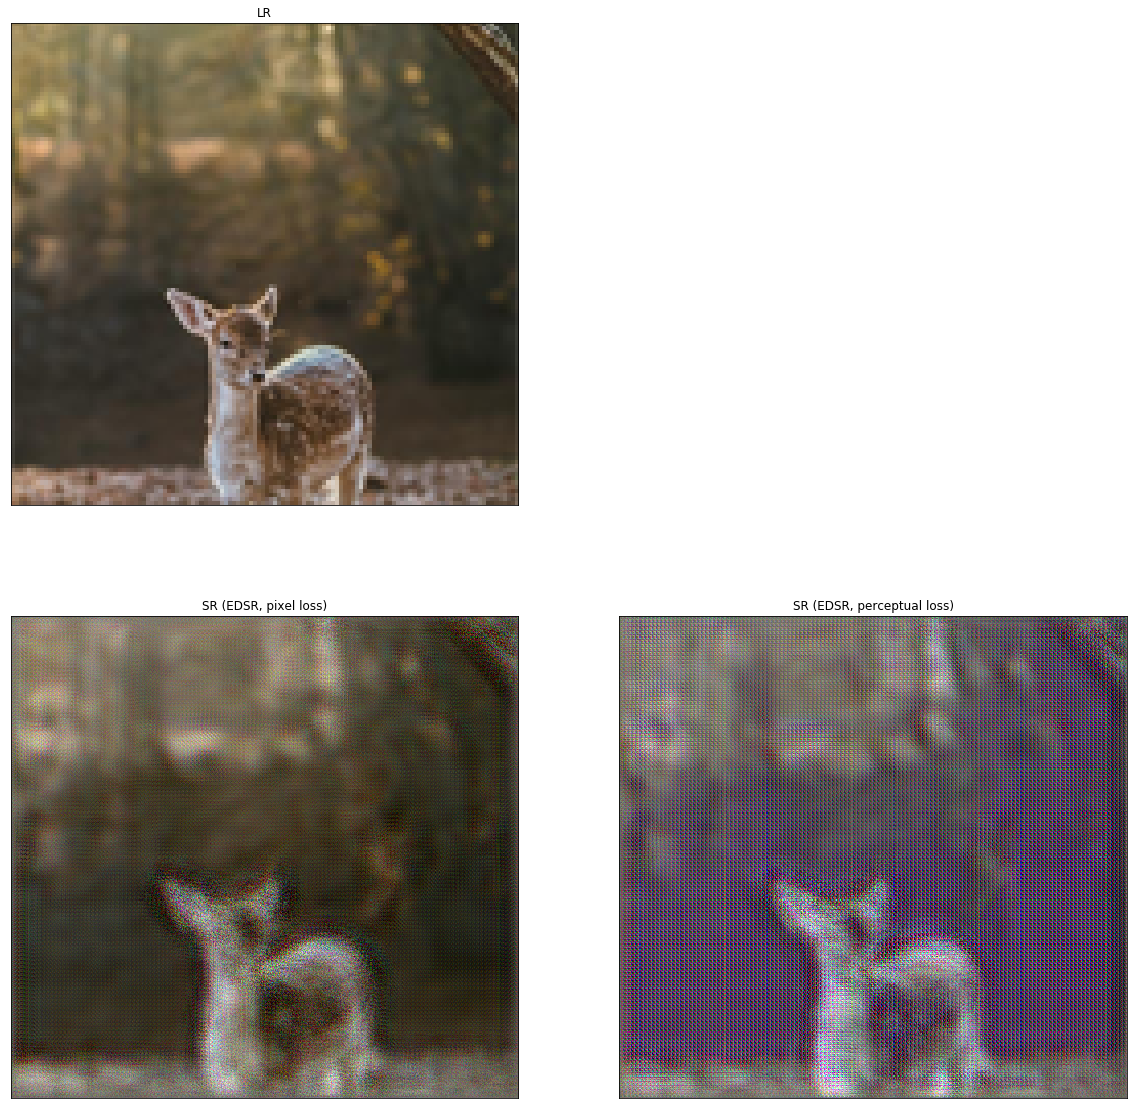

In [25]:
start = time.time()
edsr_pre_trained = edsr(scale=4, num_res_blocks=16)
edsr_pre_trained.load_weights(os.path.join(weights_dir, 'weights-edsr-16-x4.h5'))

edsr_fine_tuned = edsr(scale=4, num_res_blocks=16)
edsr_fine_tuned.load_weights(os.path.join(weights_dir, 'weights-edsr-16-x4-fine-tuned.h5'))

resolve_and_plot(edsr_pre_trained, edsr_fine_tuned, 'demo/0001x4-crop.png')
stop = time.time()
duration = stop-start
print(duration)

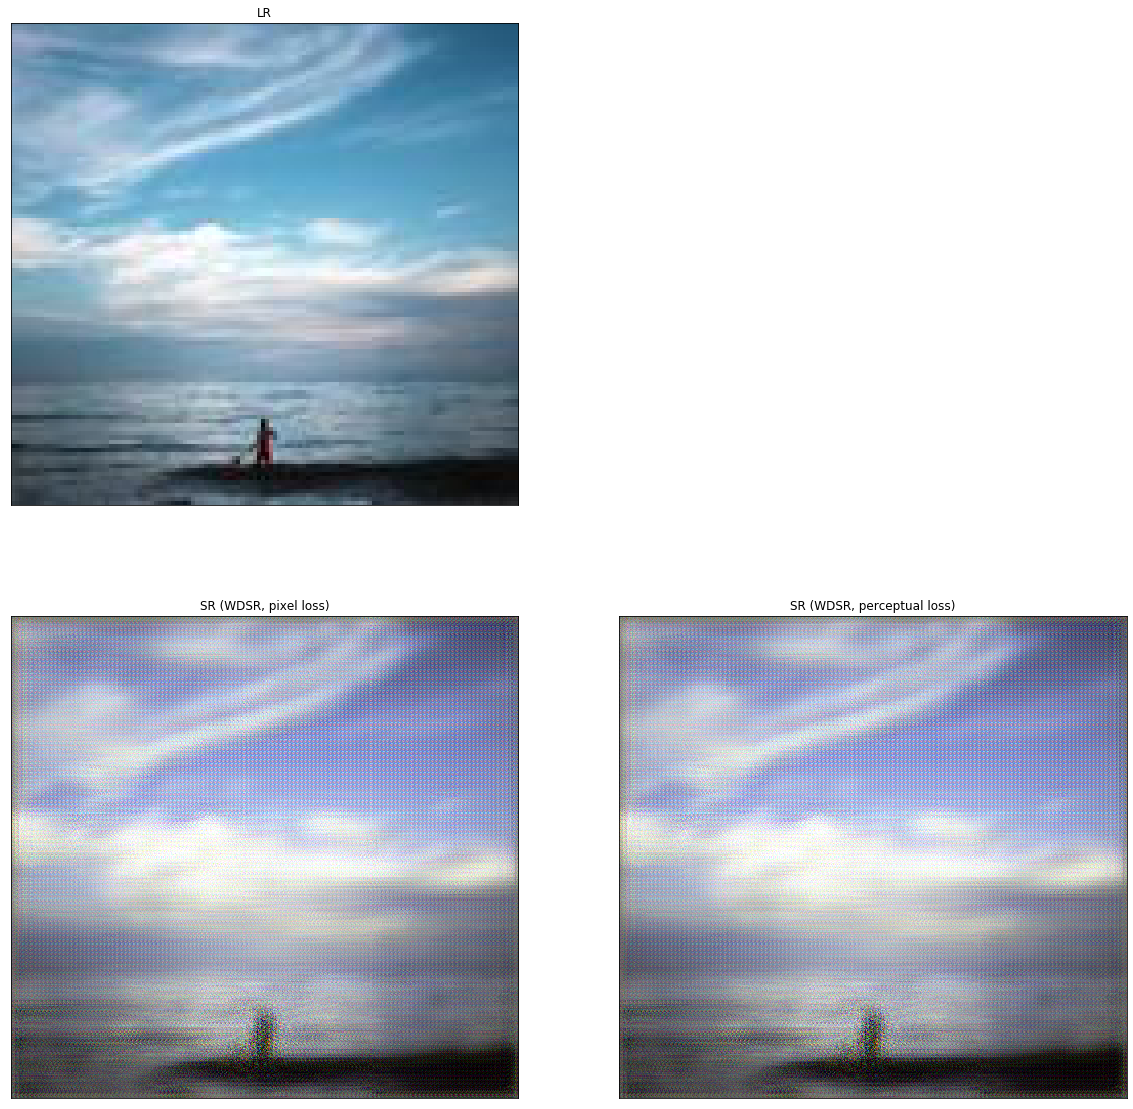

In [24]:
from model.wdsr import wdsr_b

wdsr_pre_trained = wdsr_b(scale=4, num_res_blocks=32)
wdsr_pre_trained.load_weights(os.path.join(weights_dir, 'weights-wdsr-b-32-x4.h5'))

wdsr_fine_tuned = wdsr_b(scale=4, num_res_blocks=32)
wdsr_fine_tuned.load_weights(os.path.join(weights_dir, 'weights-wdsr-b-32-x4-fine-tuned.h5'))

resolve_and_plot(wdsr_pre_trained, wdsr_fine_tuned, 'demo/0002x4-crop.png')